In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from aif360.sklearn.datasets import fetch_compas
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
X,y = fetch_compas()
X,y

(                            sex  age          age_cat              race  \
 sex    race                                                               
 Male   Other               Male   69  Greater than 45             Other   
        African-American    Male   34          25 - 45  African-American   
        African-American    Male   24     Less than 25  African-American   
        Other               Male   44          25 - 45             Other   
        Caucasian           Male   41          25 - 45         Caucasian   
 ...                         ...  ...              ...               ...   
        African-American    Male   23     Less than 25  African-American   
        African-American    Male   23     Less than 25  African-American   
        Other               Male   57  Greater than 45             Other   
 Female African-American  Female   33          25 - 45  African-American   
        Hispanic          Female   23     Less than 25          Hispanic   
 
          

In [3]:
def load_compas():
    X, y = fetch_compas()
   
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
   
    TARGET_COLUMNS = 'two_year_recid'
    data = X
    # Drop the columns 'c_charge_desc' and 'age' from the DataFrame
    data = data.drop(['c_charge_desc', 'age'], axis=1)
 
    # reset the index
 
    data, numeric_columns, categorical_columns = preprocess_dataset(data, continuous_features=[])
 
    data_df_copy = data.copy()
 
    # make y  into a dataframe
    y = pd.DataFrame(y, columns=[TARGET_COLUMNS])
    y,_,_ = preprocess_dataset(y, continuous_features=[])
 
    data[TARGET_COLUMNS] = y
       
    ### Scale the dataset
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(data_scaled, columns=data.columns)
 
    FEATURE_COLUMNS = data.columns[:-1]
   
    return data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns

In [4]:
def preprocess_dataset(df, continuous_features=[]):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()

    numeric_columns = []
    categorical_columns = []

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if the column is categorical
        if df[col].dtype == 'object' or df[col].dtype == 'category' and col not in continuous_features:
            categorical_columns.append(col)
            # If the column has only two unique values, treat it as binary categorical
            if len(df[col].unique()) == 2:
                # Label encode binary categorical features
                df[col] = label_encoder.fit_transform(df[col])
            else:
                # One-hot encode regular categorical features
                encoded_values = onehot_encoder.fit_transform(df[[col]])
                # Create new column names for the one-hot encoded features
                new_cols = [col + '_' + str(i) for i in range(encoded_values.shape[1])]
                # Convert the encoded values to a DataFrame and assign column names
                encoded_df = pd.DataFrame(encoded_values.toarray(), columns=new_cols)
                # Concatenate the encoded DataFrame with the original DataFrame
                df = pd.concat([df, encoded_df], axis=1)
                # Drop the original categorical column from the DataFrame
                df.drop(col, axis=1, inplace=True)
        # If the column is numerical but in string format and not in continuous_features, convert it to numerical type
        elif df[col].dtype == 'object' or df[col].dtype == 'category' and df[
            col].str.isnumeric().all() and col not in continuous_features:
            df[col] = df[col].astype(int)  # Convert to integer type
            categorical_columns.append(col)
        # If the column is a continuous feature, discretize it into bins
        elif col in continuous_features:
            numeric_columns.append(col)
            # Calculate the number of bins
            num_unique_values = len(df[col].unique())
            value_range = df[col].max() - df[col].min()
            num_bins = calculate_num_bins(num_unique_values, value_range)

            # Discretize into bins
            bin_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
            bins = bin_discretizer.fit_transform(df[[col]])
            # Replace the original continuous feature with the binned values
            df[col] = bins.astype(int)
        else:
            # Here are numerical columns. If the column has only 2 unique values, dont add it to numeric_columns
            if len(df[col].unique()) > 2:
                numeric_columns.append(col)
    return df, numeric_columns, categorical_columns

In [5]:
data = load_compas()
data

(      sex  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
 0     1.0            0.0             0.0         0.000000      0.000000   
 1     1.0            0.0             0.0         0.000000      0.000000   
 2     1.0            0.0             0.0         0.111111      0.105263   
 3     1.0            0.0             0.0         0.000000      0.000000   
 4     1.0            0.0             0.0         0.000000      0.368421   
 ...   ...            ...             ...              ...           ...   
 6162  1.0            0.0             0.0         0.000000      0.000000   
 6163  1.0            0.0             0.0         0.000000      0.000000   
 6164  1.0            0.0             0.0         0.000000      0.000000   
 6165  0.0            0.0             0.0         0.000000      0.078947   
 6166  0.0            0.0             0.0         0.000000      0.052632   
 
       c_charge_degree  age_cat_0  age_cat_1  age_cat_2  race_0  race_1  \
 0         

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def calculate_metrics_and_split_data(data, features, target, classifier_type='logistic_regression',
                                     metrics=['accuracy'], attribute=None, protected_attribute='sex'):
    """
    Train a classifier, predict on test data, calculate specified metrics from the confusion matrix,
    and optionally split the test data based on an attribute.

    :param data: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param classifier_type: Type of classifier ('logistic_regression', 'svm', 'random_forest', 'naive_bayes')
    :param metrics: List of metrics to calculate ('accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn')
    :param attribute: Optional attribute to split the test data on, which should be binary (0 or 1)
    :param protected_attribute: Name of the protected attribute to be removed from the feature set (default is 'sex')
    :return: Dictionary of requested metrics and optionally two DataFrames, one for each value of the attribute,
             and the trained model instance, and the preprocessor
    """
    # Step 1: Remove the protected attribute from the features
    features_without_protected = [col for col in features if col != protected_attribute]

    # Encode categorical features and scale numerical features
    categorical_features = data[features_without_protected].select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = data[features_without_protected].select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)],
        remainder='passthrough')  # Keep other columns that aren't categorized for transformation

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[features_without_protected], data[target], test_size=0.2, random_state=42)

    # Debugging: Print the shape of the train and test sets
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Initialize classifier
    classifiers = {
        'logistic_regression': LogisticRegression(max_iter=500, solver='saga'),
        'svm': SVC(probability=True),
        'random_forest': RandomForestClassifier(),
        'naive_bayes': GaussianNB()
    }
    classifier = classifiers[classifier_type]

    # Fit the classifier and predict
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]  # True Positives
    tn = cm[0, 0]  # True Negatives
    fp = cm[0, 1]  # False Positives
    fn = cm[1, 0]  # False Negatives

    # Debugging: Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics_dict = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

    # Print accuracy
    print(f"Accuracy: {metrics_dict['accuracy']}")

    # Validate metrics
    results = {}
    for metric in metrics:
        if metric not in metrics_dict:
            raise ValueError(
                f"Unsupported metric '{metric}'. Choose from 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn'.")
        results[metric] = metrics_dict[metric]

    # Step 3: Add the target and predictions back to the test set for completeness
    X_test_df = X_test.copy()
    X_test_df[target] = y_test.values
    X_test_df['pred'] = y_pred

    # Step 4: Separate True Positives (TP) and False Positives (FP)
    tp_df = X_test_df[(X_test_df[target] == 1) & (X_test_df['pred'] == 1)]  # True Positives
    fp_df = X_test_df[(X_test_df[target] == 0) & (X_test_df['pred'] == 1)]  # False Positives

    # Debugging: Print the test data with all columns (True Positives)
    print("Test data with all columns (True Positives):")
    print(tp_df.head())
    
    # Debugging: Print the test data with all columns (False Positives)
    print("Test data with all columns (False Positives):")
    print(fp_df.head())

    return results, X_test_df, pipeline, tp_df, fp_df

In [7]:
import numpy as np

# Load the dataset (assuming load_compas() works similarly to load_adult())
data, features, target, numeric_columns, categorical_columns = load_compas()

# Define the list of race-related columns that need to have random values
race_columns = ['race0', 'race1', 'race2', 'race3', 'race4', 'race5']

# Replace the values in each race-related column with random values
# Here we assume that the values in these columns are binary (0 or 1).
# Adjust accordingly if the values are different.
for col in race_columns:
    # Generate random binary values (0 or 1) with the same shape as the column
    data[col] = np.random.randint(0, 2, size=data.shape[0])

# Ensure that the race columns remain in the feature columns (we are not removing them now)
features = [col for col in features]  # Keep all original features including race columns

# Print to verify that race columns now have random values
print("Columns in data after randomizing race columns:", data.columns)
print("Randomized race columns sample:")
print(data[race_columns].head())

# Call the calculate_metrics_and_split_data function with the modified data
results, X_test_df, trained_model_pipeline, tp_df, fp_df = calculate_metrics_and_split_data(
    data=data, 
    features=features, 
    target=target
)

# Print the shape and the first few rows of tn_df and fn_df to inspect them
print("Shape of tn_df (True Negatives):", tp_df.shape)
print("First few rows of tn_df:")
print(tp_df.head())

print("\nShape of fn_df (False Negatives):", fp_df.shape)
print("First few rows of fn_df:")
print(fp_df.head())

Columns in data after randomizing race columns: Index(['sex', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'age_cat_0', 'age_cat_1',
       'age_cat_2', 'race_0', 'race_1', 'race_2', 'race_3', 'race_4', 'race_5',
       'two_year_recid', 'race0', 'race1', 'race2', 'race3', 'race4', 'race5'],
      dtype='object')
Randomized race columns sample:
   race0  race1  race2  race3  race4  race5
0      1      0      1      1      1      1
1      1      1      1      1      1      1
2      0      1      1      0      0      1
3      0      0      1      0      0      1
4      1      1      0      0      0      1
Training data shape: X_train: (4933, 14), y_train: (4933,)
Testing data shape: X_test: (1234, 14), y_test: (1234,)
Confusion Matrix:
[[313 262]
 [146 513]]
Accuracy: 0.6693679092382496
Test data with all columns (True Positives):
      juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
2827            0.0             0.0   

In [8]:
print("Columns in tn_df:", tp_df.columns)
print("Columns in fn_df:", fp_df.columns)

Columns in tn_df: Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'c_charge_degree', 'age_cat_0', 'age_cat_1', 'age_cat_2', 'race_0',
       'race_1', 'race_2', 'race_3', 'race_4', 'race_5', 'two_year_recid',
       'pred'],
      dtype='object')
Columns in fn_df: Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'c_charge_degree', 'age_cat_0', 'age_cat_1', 'age_cat_2', 'race_0',
       'race_1', 'race_2', 'race_3', 'race_4', 'race_5', 'two_year_recid',
       'pred'],
      dtype='object')


In [10]:
import lime
import lime.lime_tabular
from collections import defaultdict

def generate_lime_explanations(df, model_pipeline, features, num_features=5):
    """
    Generate LIME explanations for a given DataFrame and model.

    :param df: DataFrame containing the instances to explain
    :param model_pipeline: Trained pipeline (preprocessor + model)
    :param features: List of feature column names
    :param num_features: Number of features to include in the explanation
    :return: List of LIME explanations
    """
    explanations = []

    # Extract the preprocessor and the model from the pipeline
    preprocessor = model_pipeline.named_steps['preprocessor']
    model = model_pipeline.named_steps['classifier']

    # Transform the data using the preprocessor
    X = preprocessor.transform(df)
    
    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X, 
        feature_names=features, 
        class_names=['Under 50K', 'Over 50K'], 
        discretize_continuous=True
    )
    
    for i in range(X.shape[0]):
        exp = explainer.explain_instance(X[i], model.predict_proba, num_features=num_features)
        explanations.append(exp)
    
    return explanations

def aggregate_explanations(explanations):
    """
    Aggregate the LIME explanations and separate positive and negative contributions.

    :param explanations: List of LIME explanations
    :return: Dictionaries of aggregated positive and negative contributions
    """
    pos_contributions = defaultdict(float)
    neg_contributions = defaultdict(float)

    for exp in explanations:
        exp_list = exp.as_list()
        for feature, weight in exp_list:
            if weight > 0:
                pos_contributions[feature] += weight
            else:
                neg_contributions[feature] += weight

    return pos_contributions, neg_contributions

def print_aggregated_contributions(pos_contrib, neg_contrib):
    """
    Print the aggregated positive and negative contributions.
    """
    print("\nAggregated Positive Contributions:")
    for feature, weight in sorted(pos_contrib.items(), key=lambda x: -x[1]):
        print(f"{feature}: {weight:.4f}")

    print("\nAggregated Negative Contributions:")
    for feature, weight in sorted(neg_contrib.items(), key=lambda x: weight):
        print(f"{feature}: {weight:.4f}")

# Generate LIME explanations for each group
lime_explanations_tp = generate_lime_explanations(tp_df, trained_model_pipeline, features)
lime_explanations_fp = generate_lime_explanations(fp_df, trained_model_pipeline, features)

# Aggregate positive and negative contributions for each group
pos_contrib_tp, neg_contrib_tp = aggregate_explanations(lime_explanations_tp)
pos_contrib_fp, neg_contrib_fp = aggregate_explanations(lime_explanations_fp)

# Print aggregated positive and negative contributions
print("\nAggregated Contributions for TP Group 0:")
print_aggregated_contributions(pos_contrib_tp, neg_contrib_tp)

print("\nAggregated Contributions for FP Group 0:")
print_aggregated_contributions(pos_contrib_fp, neg_contrib_fp)


Aggregated Contributions for TP Group 0:

Aggregated Positive Contributions:
age_cat_1 <= -0.53: 54.2634
-0.51 < age_cat_0 <= 1.95: 18.6951
-0.68 < juv_other_count <= -0.47: 10.7699
-0.74 < priors_count <= 1.36: 9.5106
-0.47 < juv_other_count <= -0.25: 1.6945
race_4 > -0.25: 1.1857

Aggregated Negative Contributions:
age_cat_0 <= -0.51: -40.2260
race_4 <= -0.25: -19.2436
priors_count <= -0.74: -10.2471
juv_other_count <= -0.68: -7.8441
age_cat_1 > -0.53: -5.7167
juv_other_count > -0.25: -6.5993
race_0 <= -0.07: -0.0753

Aggregated Contributions for FP Group 0:

Aggregated Positive Contributions:
age_cat_1 <= -0.53: 25.5560
age_cat_0 > -0.51: 6.8341
-0.74 < priors_count <= 1.36: 5.0335
-0.68 < juv_other_count <= -0.47: 5.0150
-0.47 < juv_other_count <= -0.04: 1.9479
race_4 > -0.25: 0.8177

Aggregated Negative Contributions:
juv_other_count > -0.04: -5.2777
age_cat_0 <= -0.51: -23.4796
race_4 <= -0.25: -9.8660
juv_other_count <= -0.68: -1.4508
priors_count <= -0.74: -5.2566
age_cat_1 > 


Visualizing Aggregated Contributions for TP:


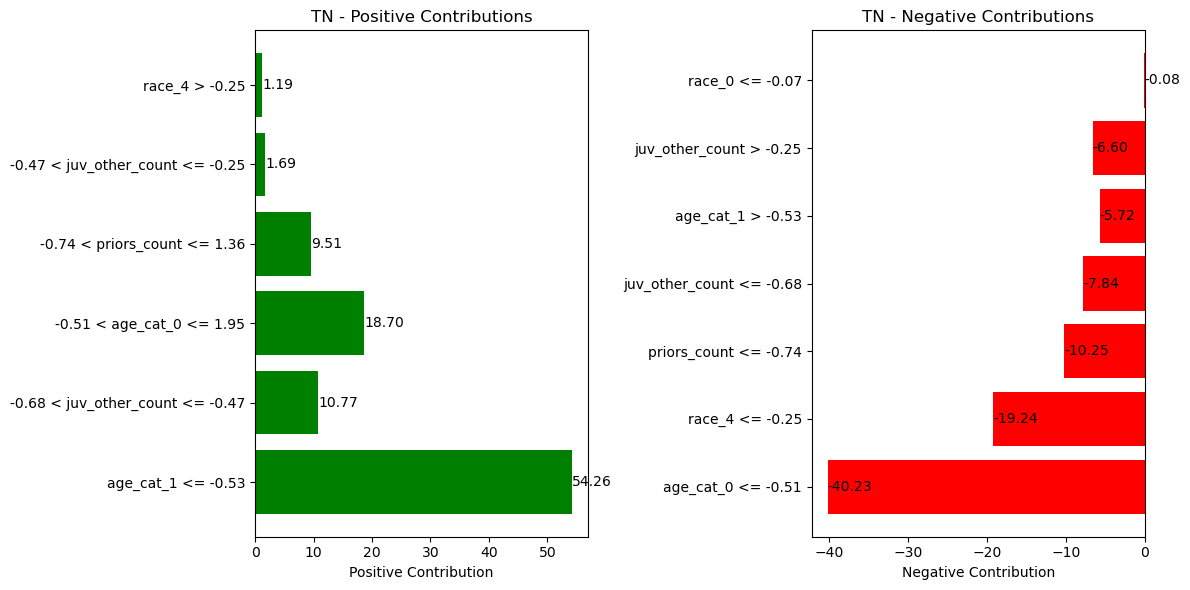


Visualizing Aggregated Contributions for FP:


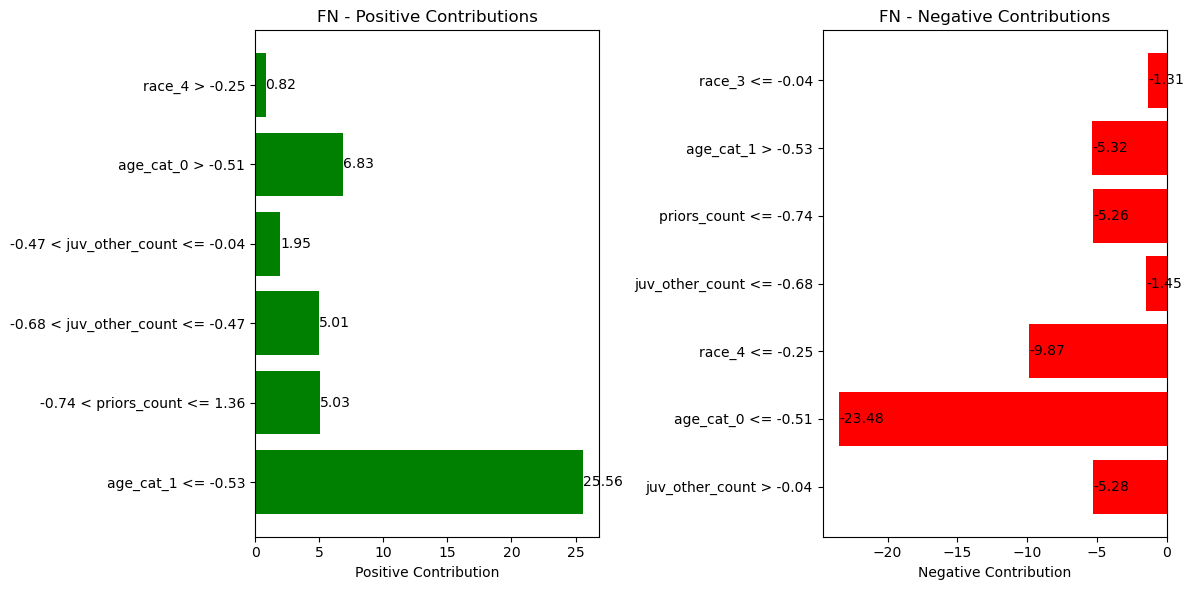

In [12]:
import matplotlib.pyplot as plt

def plot_aggregated_contributions(pos_contrib, neg_contrib, group_name):
    """
    Visualize aggregated positive and negative contributions using bar plots.
    """
    # Sort positive contributions
    pos_features = list(pos_contrib.keys())
    pos_values = list(pos_contrib.values())
    
    # Sort negative contributions
    neg_features = list(neg_contrib.keys())
    neg_values = list(neg_contrib.values())

    # Plot positive contributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(pos_features, pos_values, color='green')
    plt.xlabel('Positive Contribution')
    plt.title(f'{group_name} - Positive Contributions')

    # Add values to bars
    for i, v in enumerate(pos_values):
        plt.text(v, i, f'{v:.2f}', va='center')

    # Plot negative contributions
    plt.subplot(1, 2, 2)
    plt.barh(neg_features, neg_values, color='red')
    plt.xlabel('Negative Contribution')
    plt.title(f'{group_name} - Negative Contributions')

    # Add values to bars
    for i, v in enumerate(neg_values):
        plt.text(v, i, f'{v:.2f}', va='center')

    plt.tight_layout()
    plt.show()

# Visualize aggregated contributions for each group
print("\nVisualizing Aggregated Contributions for TP:")
plot_aggregated_contributions(pos_contrib_tp, neg_contrib_tp, "TN")

print("\nVisualizing Aggregated Contributions for FP:")
plot_aggregated_contributions(pos_contrib_fp, neg_contrib_fp, "FN")